# Сервис кикшеринга

### Импорты

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

### Функции

In [132]:
def pass_value_barh(df, df_tittle):
    try:
        (
            (df.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: "space"})
            .query("space > 0")
            .sort_values(by="space", ascending=True)
            .plot(kind="barh", figsize=(10, 5), rot=0, legend=False, fontsize=12)
            .set_title(
                f'Доля пропусков в столбцах датафрейма "{df_tittle}" (%)' + "\n",
                fontsize=16,
                color="SteelBlue",
            )
        )
    except:
        print("Пропусков нет")


def streets_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"ул\.?\s?", value="")
    return tdf


def rayons_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"\s", value="-")
    return tdf


def cat_graph(df, cat_feat, tittle):
    params = {
        "axes.labelsize": 12,
        "figure.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
    plt.rcParams.update(params)

    colors = sns.color_palette("pastel")[0:10]

    cols = 2
    num_features = len(cat_feat)
    rows = int(np.ceil(num_features / cols)) if num_features > 0 else 1

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    axs_flat = axs.flatten()

    for count, col in enumerate(cat_feat):
        if count >= len(axs_flat):
            break

        ax = axs_flat[count]

        df1 = pd.DataFrame(df.groupby([col])[col].count())
        ax.pie(
            x=df1[col],
            colors=colors,
            labels=df1.index,
            autopct="%1.1f%%",
            textprops={"fontsize": 10},
        )
        ax.title.set_text(str(col))

    for k in range(num_features, len(axs_flat)):
        fig.delaxes(axs_flat[k])

    plt.suptitle(f"Круговые диаграммы категориальных признаков {tittle}", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def plot_hist(data, col_column, tittle):
    rows = len(col_column)

    if rows == 0:
        print("Список количественных признаков пуст.")
        return

    f, ax = plt.subplots(rows, 2, figsize=(14, 8 * rows))
    f.tight_layout()
    f.set_figheight(5 * rows)
    f.set_figwidth(14)
    plt.rcParams.update({"font.size": 18})

    ax_flat = ax.flatten()

    for i, col in enumerate(col_column):

        ax_hist = ax_flat[i * 2]
        ax_box = ax_flat[i * 2 + 1]

        sns.histplot(data[col], kde=True, bins=15, ax=ax_hist)
        sns.boxplot(x=data[col], ax=ax_box)

        ax_hist.set_xlabel(col)
        ax_box.set_xlabel(col)
        ax_hist.set_ylabel("Количество")

    plt.suptitle(
        f"Гистограмма и ящик с усами для количественных данных {tittle}", fontsize=22, y=1.01
    )
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


def integer_data(df):
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    return numeric_cols


def categorial_data(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    return categorical_cols

### Загрузка датасетов

In [133]:
df_rides = pd.read_csv("datasets/rides.csv", sep=",", encoding="utf-8")
df_weather = pd.read_csv("datasets/weather.csv", sep=",", encoding="utf-8", skiprows=[1])
df_rides.columns = df_rides.columns.str.lower().str.replace(" ", "_")
df_weather.columns = df_weather.columns.str.lower().str.replace(" ", "_")

### Исправление опечаток

In [134]:
for x in ["start_location", "end_location"]:
    df_rides = streets_format(df_rides, x)

for x in ["start_district", "end_district"]:
    df_rides = rayons_format(df_rides, x)

### Назначение типов данных

In [135]:
df_rides["promo"] = df_rides["promo"].apply(lambda x: True if x == 1 else False)

df_rides["start_date"] = pd.to_datetime(df_rides["start_date"])
df_rides["end_date"] = pd.to_datetime(df_rides["end_date"])
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

## Аналитический и графический анализ

### Просмотр датасетов

#### Датасет поездок

In [136]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False


In [137]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              102255 non-null  int64         
 1   start_date      102255 non-null  datetime64[ns]
 2   end_date        101676 non-null  datetime64[ns]
 3   start_location  102255 non-null  object        
 4   start_district  102255 non-null  object        
 5   end_location    102255 non-null  object        
 6   end_district    102255 non-null  object        
 7   distance        101022 non-null  float64       
 8   promo           102255 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 6.3+ MB


Размер датасета, а значит и количество поездок

In [138]:
df_rides.shape

(102255, 9)

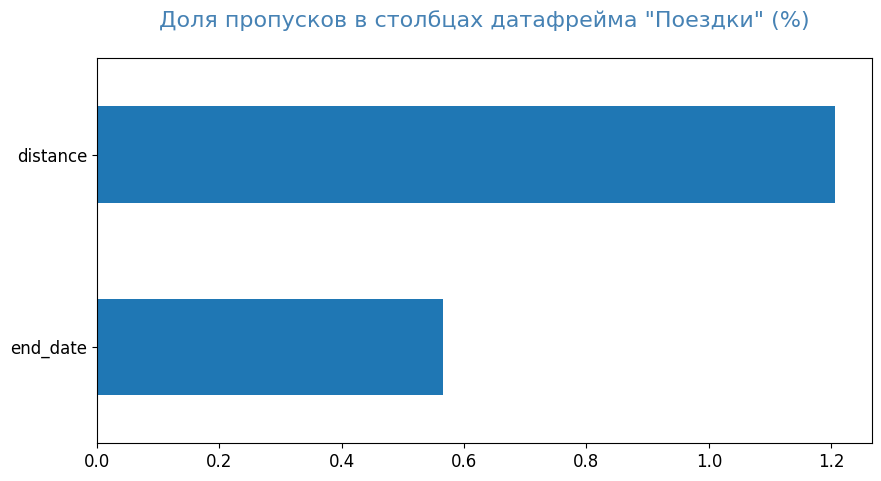

In [139]:
pass_value_barh(df_rides, "Поездки")

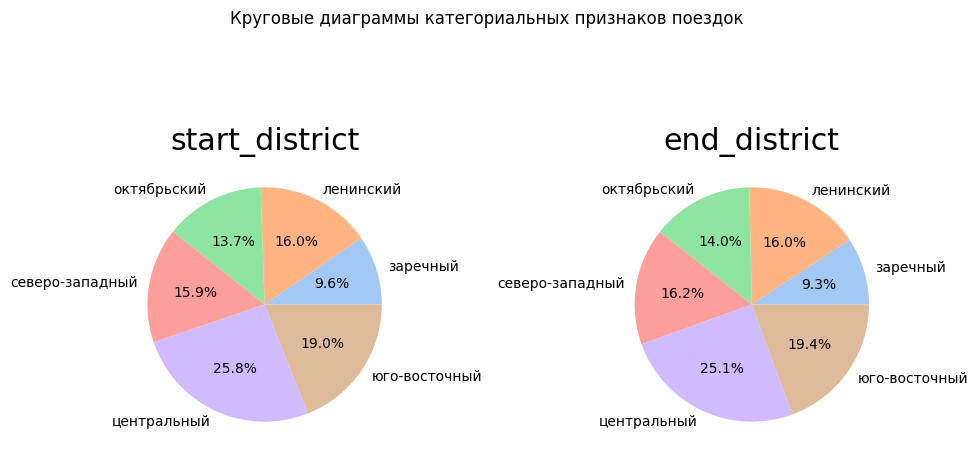

In [140]:
cat_graph(df_rides, ["start_district", "end_district"], "поездок")

#### Датасет погоды

In [141]:
df_weather.head(5)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [142]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   float64       
 2   precipitation_total  3642 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3656 non-null   float64       
 5   cloud_cover_total    3652 non-null   float64       
 6   sunshine_duration    3660 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


Размер датасета, а значит и количество измерений

In [143]:
df_weather.shape

(3672, 7)

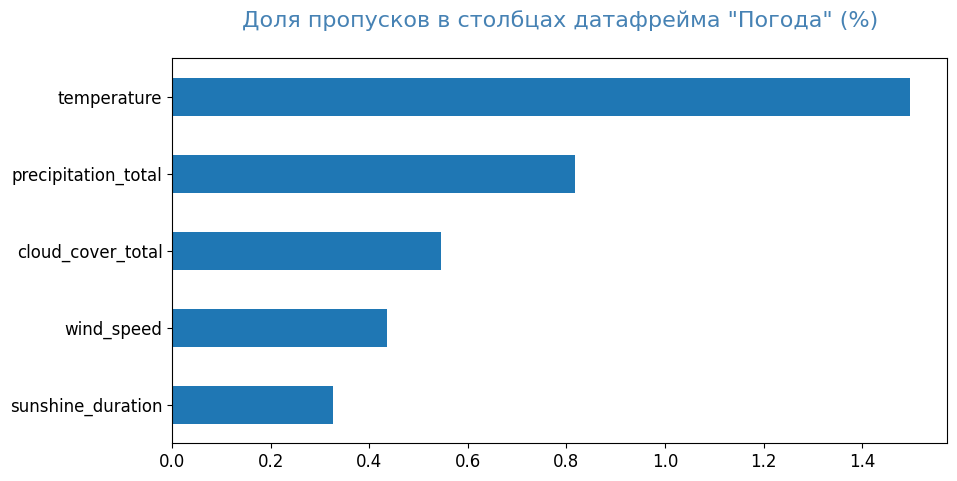

In [144]:
pass_value_barh(df_weather, "Погода")

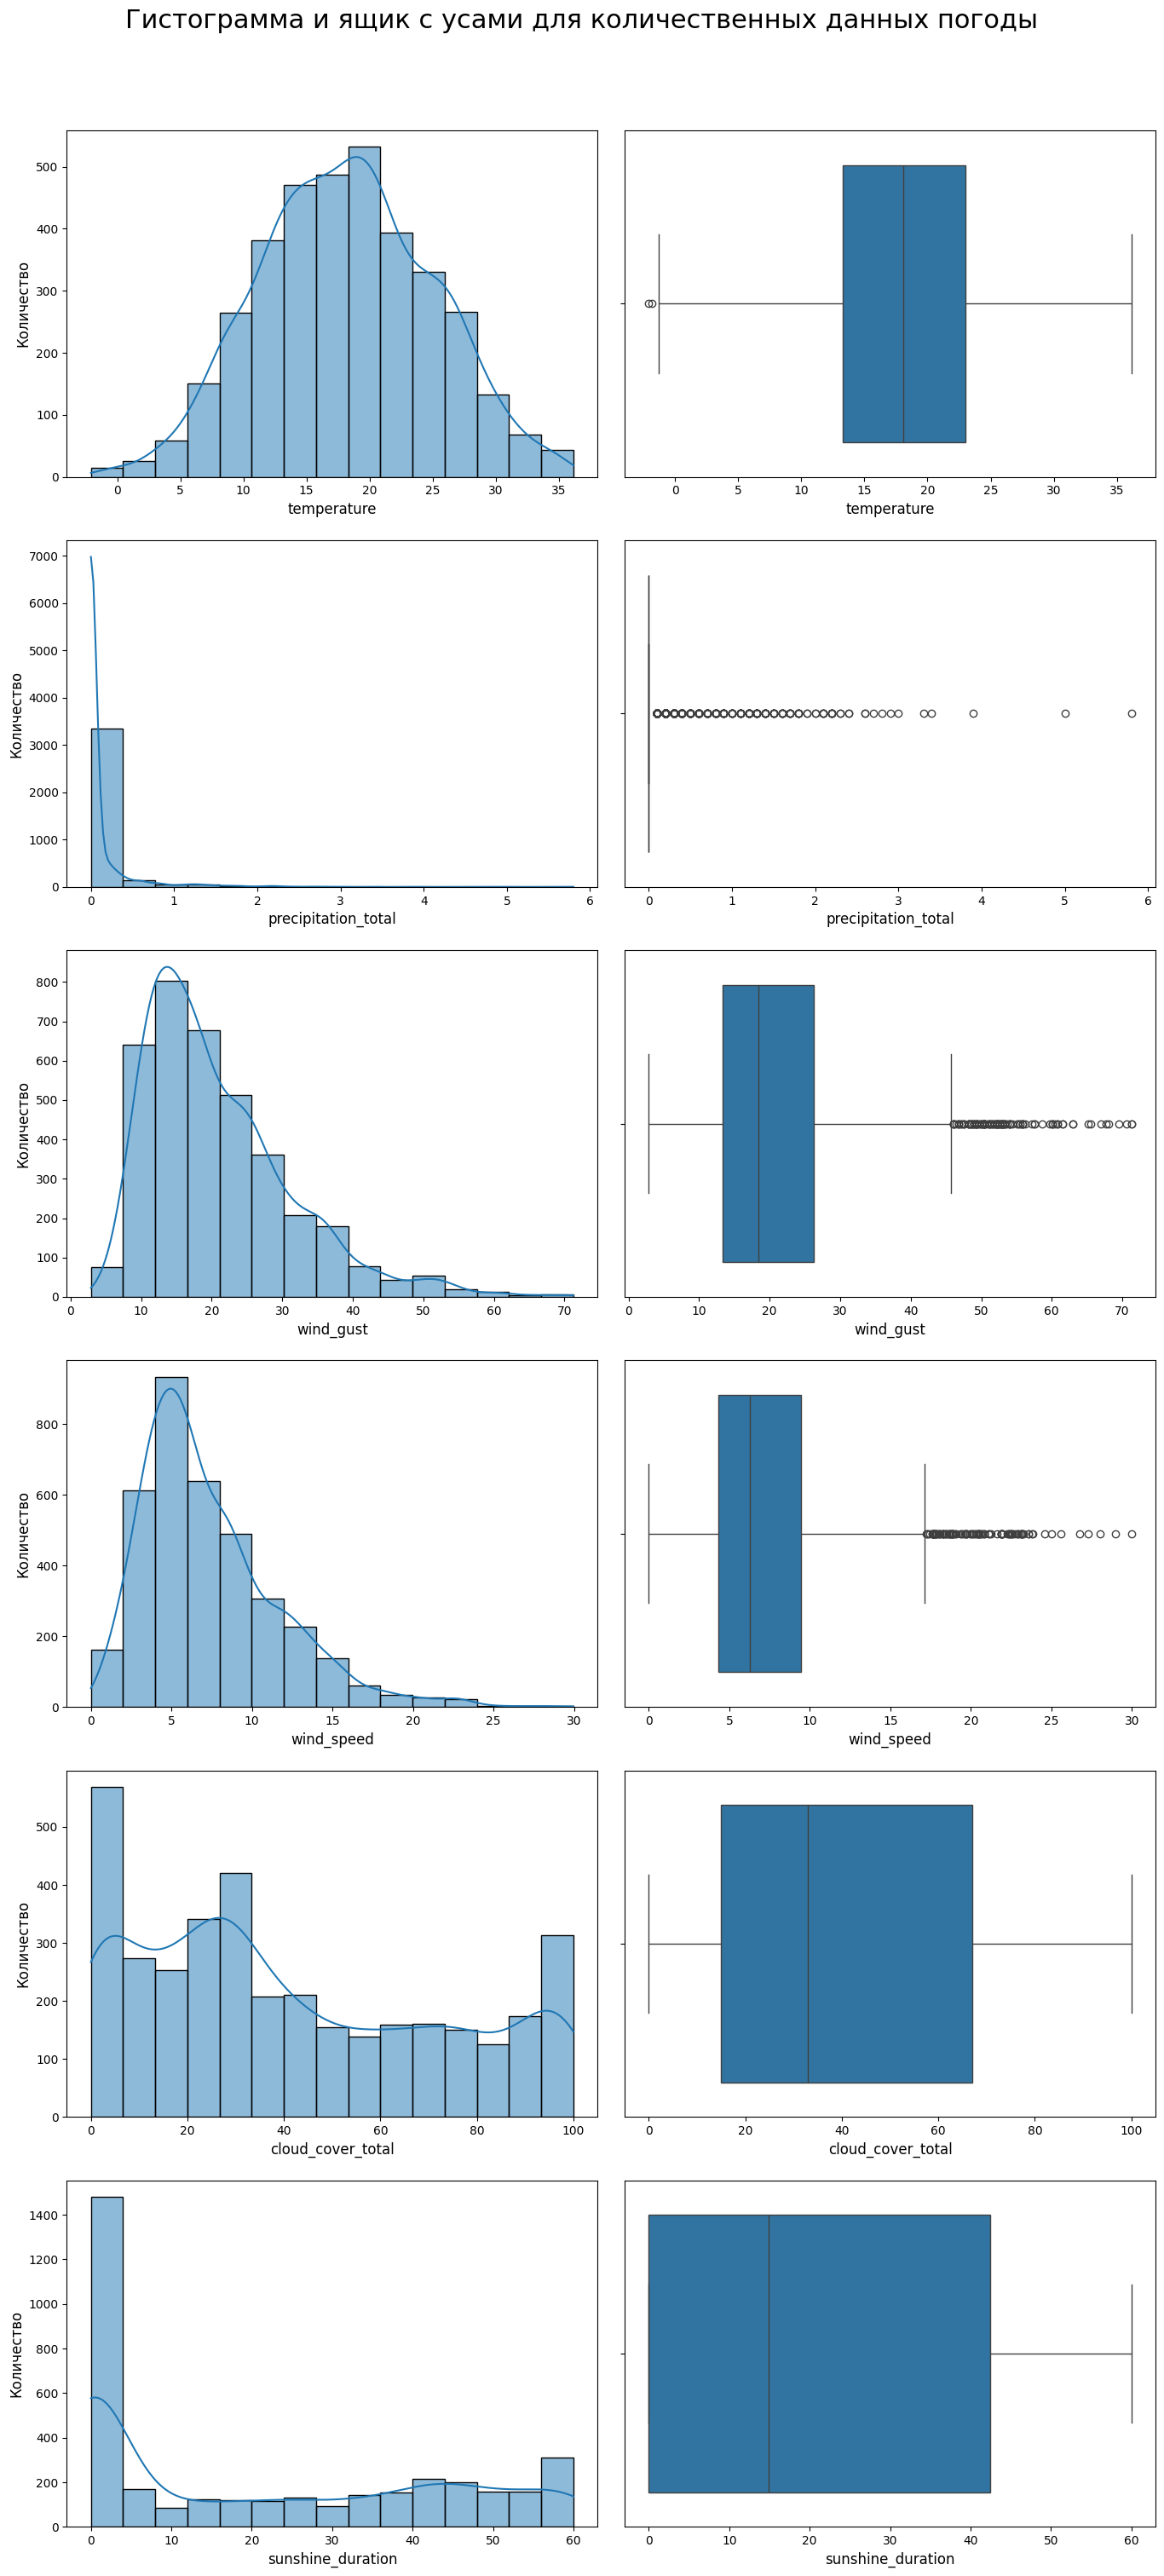

In [145]:
plot_hist(df_weather, integer_data(df_weather), "погоды")